<h1 style='text-align: center'>Predict House Popularity In New York 🥇</h1>

<p  style='text-align: center'>
This notebook is in <span style='color: green; font-weight: 700'>Active</span> state of development!
<a style='font-weight:700' href='https://github.com/LilDataScientist'> Code on GitHub! </a></p>

<div style='text-align: center'>
    <img src='https://media.istockphoto.com/photos/winter-in-manhattan-picture-id1292824324?b=1&k=20&m=1292824324&s=170667a&w=0&h=GpVutoJrAAYP_h_ddXm_hIR1_22WebYn3ym6jz6hRNQ=' width='1000' />
</div>

<h1 style='background-color: #dae8fc; border: 1px solid #94add0; padding: 10px; font-weight: 400; text-align:center'>Import Dependencies</h1>

In [1]:
import catboost
import optuna

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

from catboost import CatBoostClassifier, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

<h1 style='background-color: #dae8fc; border: 1px solid #94add0; padding: 10px; font-weight: 400; text-align:center'>Turn Off Warnings</h1>

I came across such common warnings as setting to the copy of pandas dataframe

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
pd.options.mode.chained_assignment = None

np.random.seed(0)

sns.set_style("dark")

<h1 style='background-color: #dae8fc; border: 1px solid #94add0; padding: 10px; font-weight: 400; text-align:center'>Load Dataset</h1>

In [3]:
df = pd.read_csv('../input/housepricingtg2021/train.csv')

df

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,TARGET
0,57094,1.0,3,0,2016-05-19 18:06:27,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10,medium
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,Renovated Kitchen and Bathroom!,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South,medium
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street,low
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,Newly renovated flex 2 apartment offers the ne...,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street,low
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,LOW FEE apartments do not come around like thi...,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,321 West 16th Street,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34541,25582,1.0,1,14fdc4b01ae44b025f6c4d28c9097e5f,2016-06-16 02:12:57,Newly renovated bedroom apartment located off ...,29th St,['No pets'],40.7653,7166867,-73.9248,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7166867_625fde3...,1950,30-95 29th St,low
34542,50013,1.0,0,9b6cf886379a2511f8c633c84028efe7,2016-05-10 03:17:32,All apartments are newly renovated featuring: ...,E 1st St,"['Pre-War', 'Laundry in Unit', 'Dishwasher', '...",40.7239,6989251,-73.9901,5599e962719af3ccc2976855c2d5893c,['https://photos.renthop.com/2/6989251_42a4884...,2600,39 E 1st St,medium
34543,111475,2.0,2,0,2016-04-21 03:29:35,"<![CDATA[2 bedrooms, 5110, Astoria / Long Isla...",50th Avenue,[],40.7437,6905568,-73.9585,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/6905568_01602e3...,5110,2-01 50th Avenue,low
34544,71184,1.0,2,8754cae39f6e053974aa2337017eb3c1,2016-05-14 02:27:47,CooperCooper.com :: Listing ID #10_0385; 400 W...,400 West 56th Street,"['Laundry in Unit', 'Dishwasher', 'Cats Allowe...",40.7673,7010187,-73.9866,6e5c10246156ae5bdcd9b487ca99d96a,['https://photos.renthop.com/2/7010187_ab1db5d...,3400,400 West 56th Street,medium


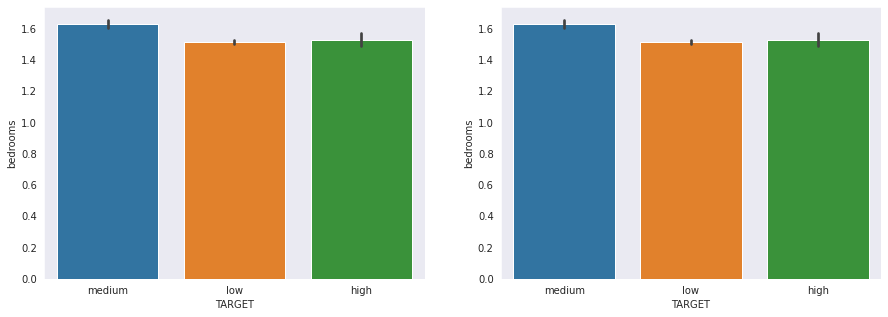

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x="TARGET", y="bedrooms", data=df, ax=ax[0]);
sns.barplot(x="TARGET", y="bedrooms", data=df, ax=ax[1]);

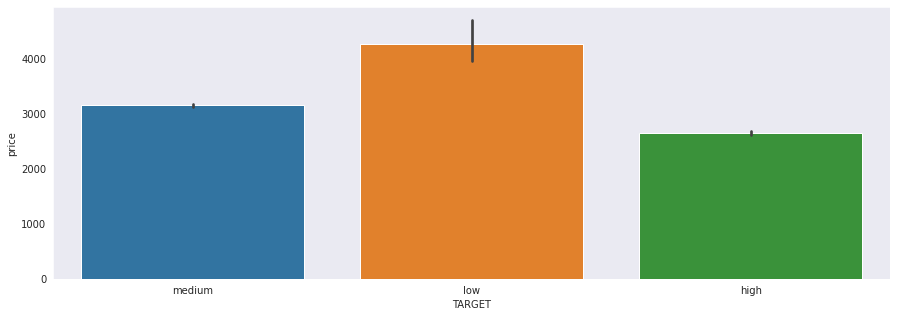

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.barplot(x="TARGET", y="price", data=df, ax=ax);

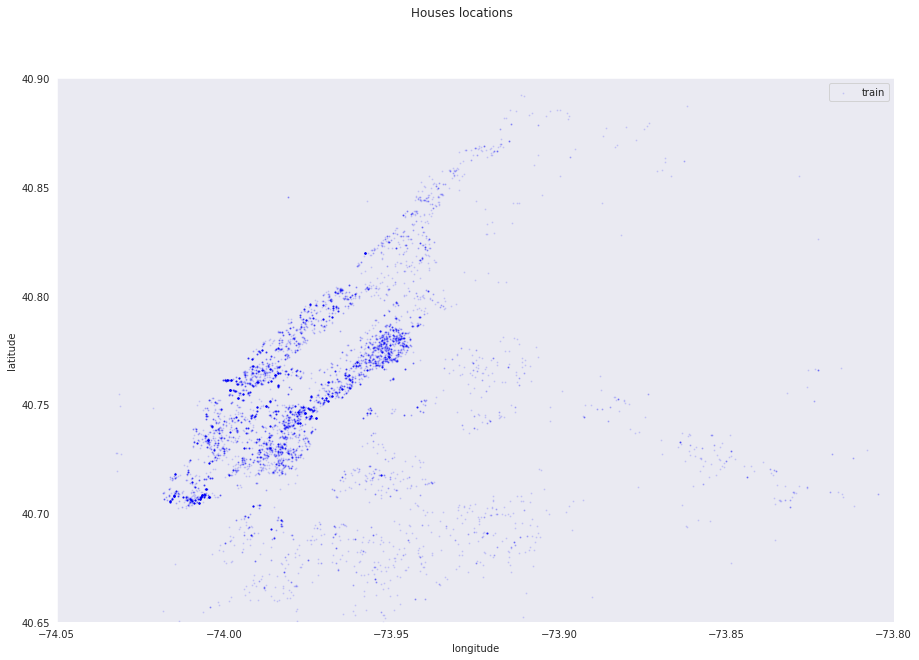

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
N = 10000
ax.scatter(df['longitude'].values[:N], df['latitude'].values[:N],
           color='blue', s=1, label='train', alpha=0.1)

fig.suptitle('Houses locations')
ax.legend(loc=0)
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim((40.65, 40.9))
plt.xlim((-74.05, -73.8))
plt.show()

<h1 style='background-color: #dae8fc; border: 1px solid #94add0; padding: 10px; font-weight: 400; text-align:center'>Extra classes for feature engineering</h1>

Since such columns as **description, display_address, features and street_address** looks like a bunch of strings we would like to gain some information form them, probably one hot them, and for doing it I will introduce **BaseExtracter** class that will extract words from string of strings and **BaseMultiLabelBinarizer** that will one hot all these features!

In [7]:
class BaseExtracter(BaseEstimator, TransformerMixin):
    def __init__(self, column, extraction_function):
        self.extraction_function = extraction_function
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.column] = X_[self.column].apply(self.extraction_function) 
        return X_
    
class BaseMultiLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.mlb = MultiLabelBinarizer()
        self.column = column
    
    def fit(self, X, y=None):
        self.mlb.fit(X[self.column])
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        encoded = pd.DataFrame(self.mlb.transform(X_[self.column]), columns=self.mlb.classes_)
        X_ = pd.concat([X_.reset_index(), encoded], axis=1)  

        X_.drop(columns=['index', self.column], inplace=True)

        return X_

Since it is much easier to deal with pandas, we will implement our **PandasSimpleImputer**. The point of doing this was that **sklearn.impute.SimpleImputer** returns numpy array while for this particular task we want our data to be in pandas format

In [8]:
class PandasSimpleImputer(SimpleImputer):
    def fit(self, X, y=None):
        self.columns = X.columns
        return super().fit(X, y)

    def transform(self, X):
        return pd.DataFrame(super().transform(X), columns=self.columns)

<h1 style='background-color: #dae8fc; border: 1px solid #94add0; padding: 10px; font-weight: 400; text-align:center'>Feature Engineering</h1>

Let's add some Nonlinearity to our model by adding more features.

In [9]:
class GenerateMoreFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        coords = np.vstack((X[['latitude', 'longitude']].values))
        self.pca = PCA().fit(coords)
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()

        X_[f'pca{0}'] = self.pca.transform(X_[['latitude', 'longitude']])[:, 0]
        
        """Price per bedroom and bathroom"""
        
        X_['price_per_bedroom']  = X_["price"] / X_["bedrooms"]
        X_["price_per_bathroom"] = X_["price"] / X_["bathrooms"]
        X_['price_per_bedroom'][X_['price_per_bedroom'] == np.Inf] = 0
        X_['price_per_bathroom'][X_['price_per_bathroom'] == np.Inf] = 0
        X_.drop(columns=['bedrooms','bathrooms'], inplace=True)
        
        """Seller and Building popularity"""
        
        building_ids = X_['building_id'].value_counts()
        manager_ids = X_['manager_id'].value_counts()
        X_['manager_ids_count'] = X_['manager_id'].apply(lambda x: manager_ids[x] if x in manager_ids else 0)
        X_['building_ids_count'] = X_['building_id'].apply(lambda x: building_ids[x] if x in building_ids else 0)
        X_.drop(columns=['manager_id','building_id'], inplace=True)
        
        """Date and time"""
        
        X_["created"] = X_["created"].astype("datetime64")
        X_['Weekday'] = X_.created.dt.weekday
        X_['day_of_month'] = X_.created.dt.day
        X_['hour'] = X_.created.dt.hour
        X_['is_weekend'] = X_.created.apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)
        X_['month'] = X_.created.dt.month
        X_['week'] = X_.created.dt.isocalendar().week
        X_['minute'] = X_['created'].dt.minute
        X_['pickup_week_hour'] = X_['Weekday'] * 24 + X_['hour']
        
        timestamp = pd.Timestamp('2016-06-29 18:30:41')
        
        X_['days_since_last'] = X_.created.apply(lambda x: (timestamp - x).days)

        X_.drop(columns=['created'], inplace=True)
        
        return X_

<h1 style='background-color: #dae8fc; border: 1px solid #94add0; padding: 10px; font-weight: 400; text-align:center'>Pipeline</h1>

Now we are ready to build a pipeline for our particular problem. For such encoded features as **display_address, features and street_address** we will use **VarianceThreshold** which basically removes elements by variance threshold> If you would skip this turn you would end up having million of features!

In [10]:
features = make_pipeline(PandasSimpleImputer(strategy='constant', fill_value='xxx'),
                         BaseExtracter('features', lambda x: x[1:-1].replace("'", "").replace(" ", "").split(',')),
                         BaseMultiLabelBinarizer('features'),
                         VarianceThreshold(threshold=0.01))

display_address = make_pipeline(PandasSimpleImputer(strategy='constant', fill_value='xxx'),
                                BaseExtracter('display_address', lambda x: x.split(' ')),
                                BaseMultiLabelBinarizer('display_address'),
                                VarianceThreshold(threshold=0.01))

street_address= make_pipeline(PandasSimpleImputer(strategy='constant', fill_value='xxx'),
                              BaseExtracter('street_address', lambda x: x.split(' ')),
                              BaseMultiLabelBinarizer('street_address'),
                              VarianceThreshold(threshold=0.01))

special_features = make_pipeline(GenerateMoreFeatures(), StandardScaler())

polynomial_features = make_pipeline(PolynomialFeatures(2), StandardScaler())

columns = ColumnTransformer(transformers=[
        ('Special Features', special_features, ['price', 'bedrooms', 'bathrooms', 
                                                'building_id', 'manager_id', 'created',
                                                'latitude', 'longitude', 'listing_id']),
        ('Polynomial Features', polynomial_features, ['price', 'bedrooms', 'bathrooms',
                                                      'latitude', 'longitude', 'listing_id']),
        ('Features', features, ['features']),
        ('Display Address', display_address, ['display_address']),
        ('Street Address', street_address, ['street_address']),
])

Now we are ready to split our data and start training

In [11]:
X, y = df.loc[:, df.columns != 'TARGET'], df.loc[:, 'TARGET']

le = LabelEncoder()

y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

In [12]:
X_train = columns.fit_transform(X_train);
X_test  = columns.transform(X_test)

features_num = X_train.shape[1]

print(f'Generated {features_num} features')

Generated 119 features


Dealing with class imbalance problem

In [13]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

class_weights

{0: 4.248263888888889, 1: 0.4790290216806147, 2: 1.4769880790704693}

<h1 style='background-color: #dae8fc; border: 1px solid #94add0; padding: 10px; font-weight: 400; text-align:center'>Feature Selection</h1>

Since while some features are good other may not be like that and that's why we need to select the ones which perfoms the best for our model

In [14]:
features_select = 90

clf = CatBoostClassifier(class_weights=class_weights, verbose=0,
                                    task_type="GPU", devices='0', random_seed=0,
                                    iterations=2000, depth=5, l2_leaf_reg=4,
                                    leaf_estimation_method='Newton')
            
train_pool = catboost.Pool(data=X_train, label=y_train)
test_pool = catboost.Pool(data=X_test, label=y_test)

summary = clf.select_features(train_pool, eval_set=test_pool,
                              features_for_select=f'0-{features_num - 1}',
                              num_features_to_select=features_select,steps=5,
                              logging_level='Silent',
                              algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
                              shap_calc_type=EShapCalcType.Regular, train_final_model=False);

selected_features = summary['selected_features']

X_train_subset = X_train[:, selected_features]
X_test_subset  = X_test[:, selected_features]

<h1 style='background-color: #dae8fc; border: 1px solid #94add0; padding: 10px; font-weight: 400; text-align:center'>Hyperparameters Tuning</h1>

Since we are using **Gradient Boosting** we have to choose between different depth for trees, number of iterations and other important hyperparameters

In [15]:
def objective(trial):
    depth = trial.suggest_int("rf_max_depth", 3, 6, log=True)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 2, 30, log=True)
    iterations = trial.suggest_discrete_uniform("iterations", 2000, 3000, q=500)

    all_scores = []
    for seed in np.random.randint(0, 100, size=(5)):
        clf = CatBoostClassifier(class_weights=class_weights, verbose=0, 
                                 task_type="GPU", devices='0', random_seed=seed,
                                 iterations=iterations, depth=depth,
                                 l2_leaf_reg=l2_leaf_reg)
                    
        clf.fit(X_train_subset, y_train)
        score = balanced_accuracy_score(y_test, clf.predict(X_test_subset))
        all_scores.append(score)

    average_score = sum(all_scores) / len(all_scores)
    return average_score
                

sampler = optuna.samplers.TPESampler(seed=0)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=5)
study.best_params

[I 2021-12-19 23:26:25,524] A new study created in memory with name: no-name-294ae944-43a0-462c-80af-19e67fccdad0
[I 2021-12-19 23:27:36,830] Trial 0 finished with value: 0.6193780874374827 and parameters: {'rf_max_depth': 4, 'l2_leaf_reg': 13, 'iterations': 2500.0}. Best is trial 0 with value: 0.6193780874374827.
[I 2021-12-19 23:28:47,420] Trial 1 finished with value: 0.6234822797922028 and parameters: {'rf_max_depth': 4, 'l2_leaf_reg': 5, 'iterations': 2500.0}. Best is trial 1 with value: 0.6234822797922028.
[I 2021-12-19 23:30:11,774] Trial 2 finished with value: 0.6228466711520155 and parameters: {'rf_max_depth': 4, 'l2_leaf_reg': 22, 'iterations': 3000.0}. Best is trial 1 with value: 0.6234822797922028.
[I 2021-12-19 23:31:22,548] Trial 3 finished with value: 0.6215219175071207 and parameters: {'rf_max_depth': 4, 'l2_leaf_reg': 16, 'iterations': 2500.0}. Best is trial 1 with value: 0.6234822797922028.
[I 2021-12-19 23:32:20,019] Trial 4 finished with value: 0.6180792140515277 and

{'rf_max_depth': 4, 'l2_leaf_reg': 5, 'iterations': 2500.0}

<h1 style='background-color: #dae8fc; border: 1px solid #94add0; padding: 10px; font-weight: 400; text-align:center'>Train final model and submit to competition</h1>

In [16]:
clf = CatBoostClassifier(class_weights=class_weights, verbose=0, 
                                 task_type="GPU", devices='0', random_seed=42,
                                 iterations=2500, depth=4,
                                 l2_leaf_reg=5)

clf.fit(X_train_subset, y_train);

In [17]:
df_test = pd.read_csv('../input/housepricingtg2021/test.csv')
ID = df_test['Id']
df_test = columns.transform(df_test)
new_df_test = df_test[:, selected_features]
preds = clf.predict(new_df_test, prediction_type='Class')
preds = le.inverse_transform(preds)
output = pd.DataFrame({'Id': ID,'TARGET': preds})
output.to_csv('submission.csv', index=False)